<a href="https://colab.research.google.com/github/groverdharini/Sentiment-Analysis-using-Twitter-Dataset/blob/master/HCL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet tokenizers
!pip install --quiet sentencepiece

     |████████████████████████████████| 2.2MB 5.9MB/s 
     |████████████████████████████████| 3.3MB 23.8MB/s 
     |████████████████████████████████| 870kB 44.8MB/s 
     |████████████████████████████████| 839kB 4.4MB/s 
     |████████████████████████████████| 276kB 43.2MB/s 
     |████████████████████████████████| 184kB 38.2MB/s 
     |████████████████████████████████| 112kB 47.1MB/s 
     |████████████████████████████████| 829kB 33.6MB/s 
     |████████████████████████████████| 1.3MB 39.5MB/s 
     |████████████████████████████████| 143kB 47.3MB/s 
     |████████████████████████████████| 296kB 42.4MB/s 
     |████████████████████████████████| 1.2MB 5.5MB/s 


In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Twitter_Data.csv to Twitter_Data.csv


In [ ]:
df = pd.read_csv('Twitter_Data.csv')

In [ ]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [ ]:
df[df['clean_text'].isnull()].index

Int64Index([148, 158694, 159443, 160560], dtype='int64')

In [ ]:
df[df['category'].isnull()].index

Int64Index([130448, 155642, 155698, 155770, 158693, 159442, 160559], dtype='int64')

In [ ]:
df = df.drop([148, 158694, 159443, 160560,130448, 155642, 155698, 155770, 158693, 159442, 160559])
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Twitter Category')

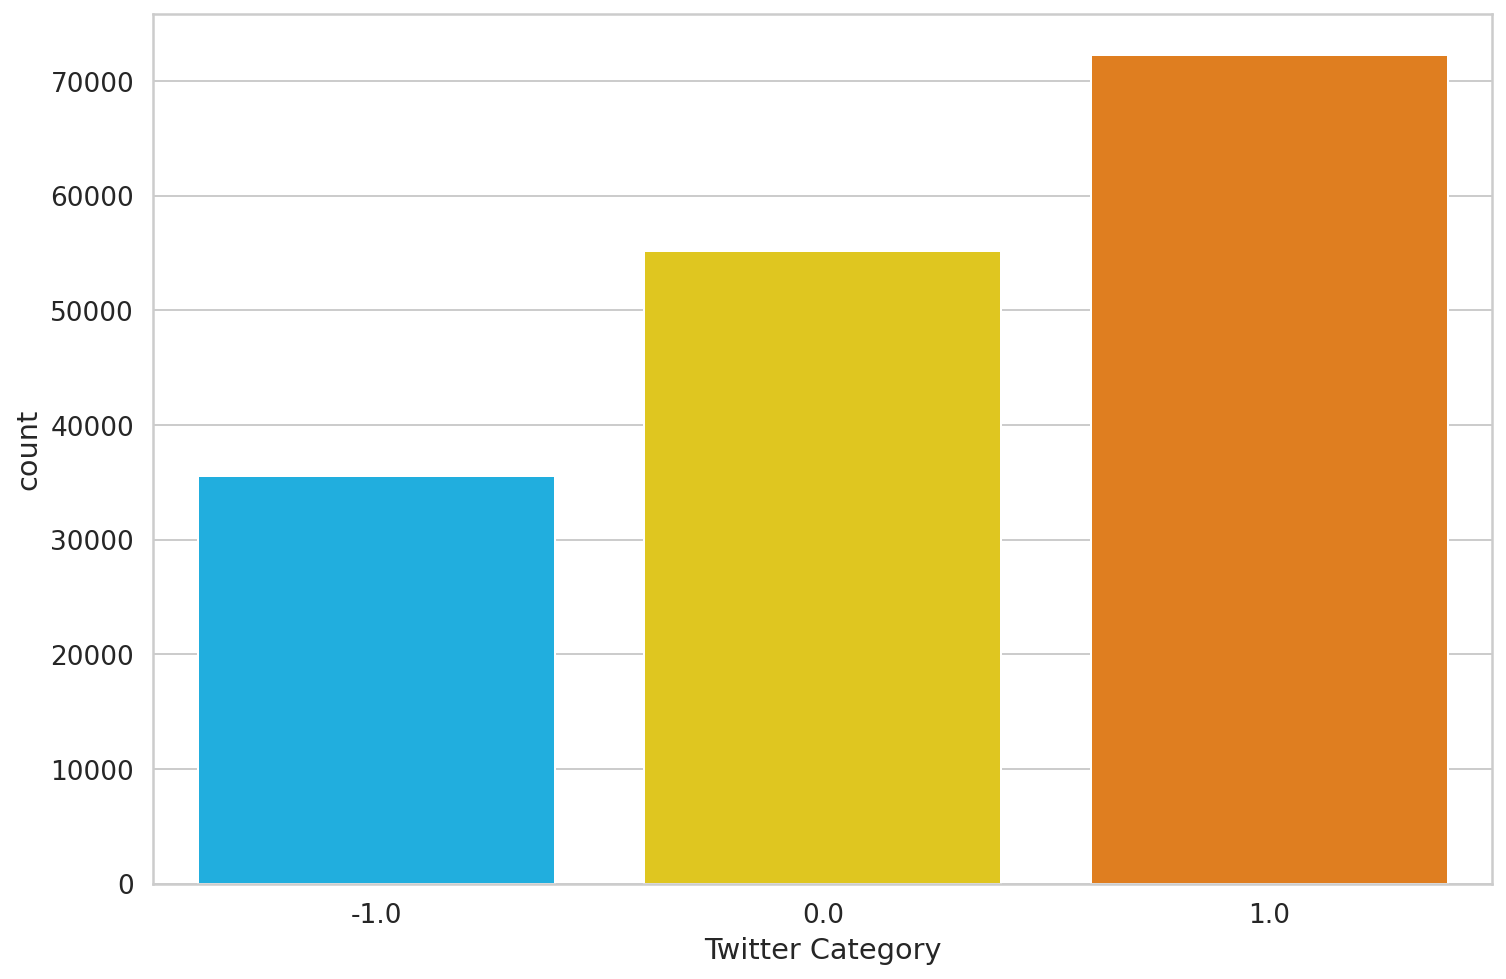

In [ ]:
sns.countplot(df.category)
plt.xlabel('Twitter Category')

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating == -1:
    return 0
  elif rating == 0 :
    return 1
  else:
    return 2


In [ ]:
df['sentiment'] = df.category.apply(to_sentiment)

In [ ]:
df.category.value_counts() 

 1.0    72249
 0.0    55211
-1.0    35509
Name: category, dtype: int64

In [ ]:
g = df.groupby('category')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

In [ ]:
df.category.value_counts() 

 1.0    35509
 0.0    35509
-1.0    35509
Name: category, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


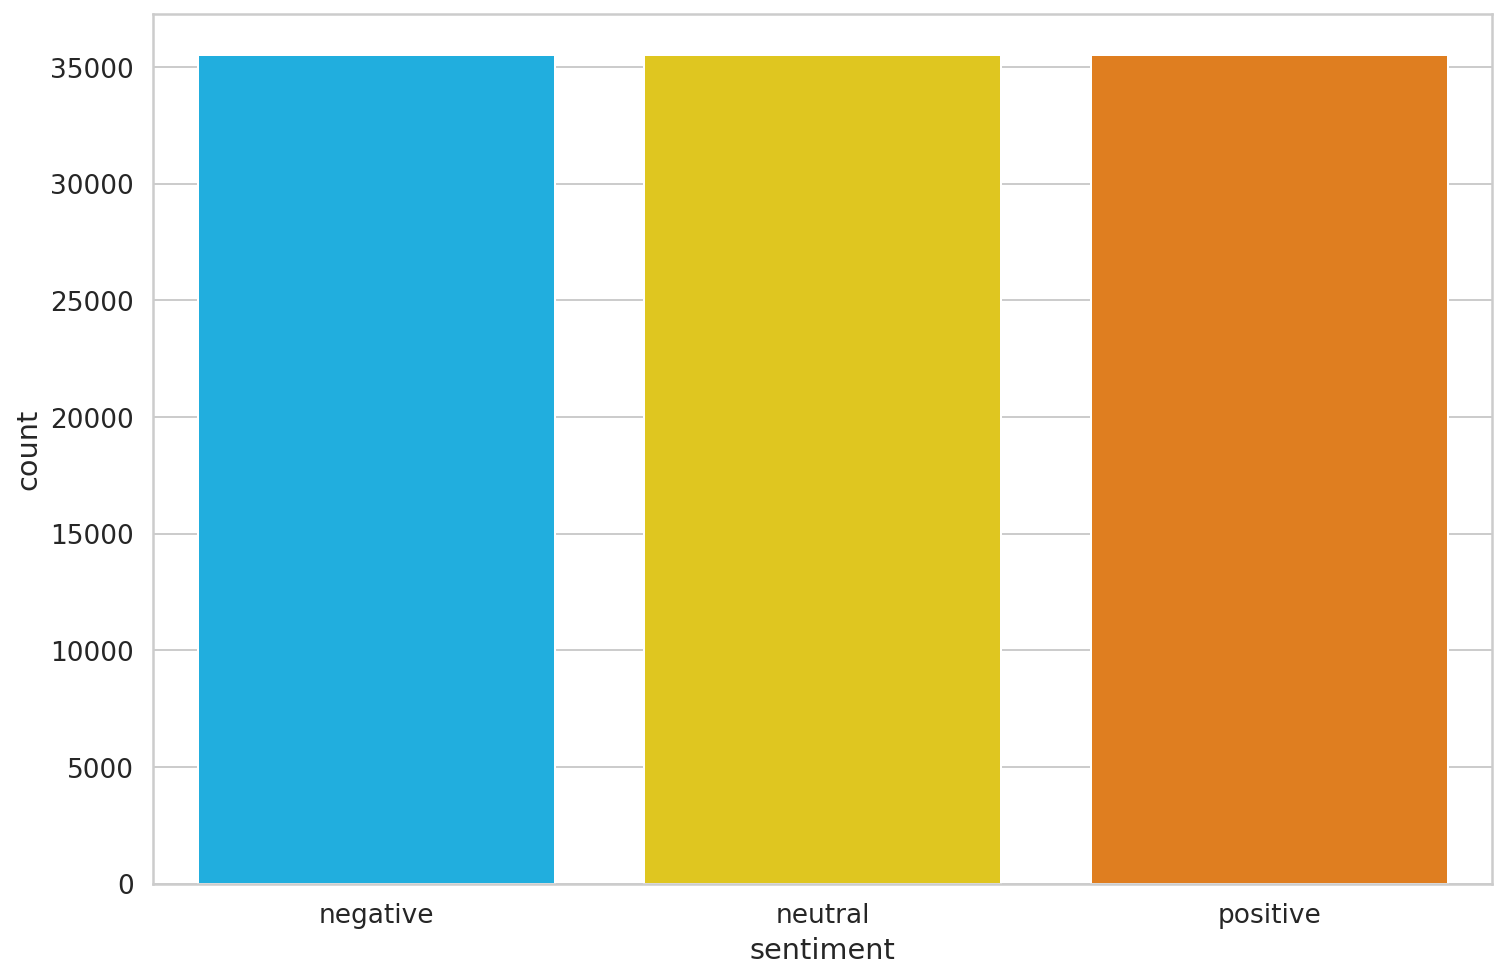

In [ ]:
class_names = ['negative','neutral', 'positive']
ax = sns.countplot(df.sentiment)
ax.set_xticklabels(class_names);

In [ ]:
df = df.sample(frac=1)
df

clean_text  ...  sentiment
category                                                           ...           
-1.0     7255   why the above mentioned achievements the previ...  ...          0
 0.0     21951  hoping that all the questions related for indi...  ...          1
         29217  already you have been used ace garner morality...  ...          1
 1.0     30856  both are wrong but there huge difference betwe...  ...          2
 0.0     9995   difference between mallya nirav modi case nira...  ...          1
...                                                           ...  ...        ...
         21861           namo merchandise owaisi brothers attack   ...          1
         26019  inspite repeated warnings from election commis...  ...          1
-1.0     2200   india’ narendra modi projects military might t...  ...          0
 0.0     33628  what was the need for modi the time election v...  ...          1
-1.0     6447   unfortunate incidence which now affects our co...  ...          0

[106527 rows x 3 columns]

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
MAX_LEN= 280
BATCH_SIZE = 32

In [ ]:
class TwitterSentimentDataset(Dataset):
  def __init__(
      self, tweets, targets, tokenizer, max_len
      ):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweets = str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      tweets,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
  
    return {
      'tweet_text': tweets,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.06,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
df_train.shape, df_test.shape, df_test.shape

((100135, 3), (3196, 3), (3196, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TwitterSentimentDataset(
    tweets=df.clean_text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )	
  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [ ]:
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

In [ ]:
'''data = next(iter(train_data_loader))
data.keys()'''

'data = next(iter(train_data_loader))\ndata.keys()'

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)
  def forward(self, input_ids, attention_mask):
    output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    ) 
    pooled_output = output[1]
    output = self.drop(pooled_output)
    return self.out(output)
    return self.softmax(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    optimizer.zero_grad()
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    loss = loss_fn(outputs, targets)
    _, preds = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
   
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    with torch.no_grad():
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    best_accuracy = val_acc

Epoch 1/5
----------


In [ ]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [ ]:
df_train.shape, df_test.shape, df_test.shape

((100135, 3), (3196, 3), (3196, 3))

In [ ]:
df_train.head()

clean_text  ...  sentiment
category                                                           ...           
 0.0     3476   bring italy cuz you will never become prime mi...  ...          1
-1.0     168    feel bad for bjp folks last years many them ma...  ...          0
 1.0     11067  full family support modi specially lil angel w...  ...          2
         18159  bcoz big deal should have been done years ago ...  ...          2
-1.0     22189  the last five years narendra modi forgave lakh...  ...          0

[5 rows x 3 columns]

In [ ]:
df_test.head()

clean_text  ...  sentiment
category                                                           ...           
-1.0     35064  video man saying that modi was involved enough...  ...          0
 1.0     5461   more required rahul gandhi than modi because f...  ...          2
 0.0     31831  knowshe will punished for his gold scamnirav m...  ...          1
         34531                                 raga not even modi  ...          1
-1.0     31011  india fearful another term upa not modi first ...  ...          0

[5 rows x 3 columns]

In [ ]:
df_train.isnull().any()
df_test.isnull().any()

clean_text    False
category      False
sentiment     False
dtype: bool

In [ ]:
df_train['len'] = df_train['clean_text'].str.len()
df_test['len'] = df_test['clean_text'].str.len()

df_train.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


clean_text  ...  len
category                                                           ...     
 0.0     3476   bring italy cuz you will never become prime mi...  ...   68
-1.0     168    feel bad for bjp folks last years many them ma...  ...  241
 1.0     11067  full family support modi specially lil angel w...  ...   89
         18159  bcoz big deal should have been done years ago ...  ...  188
-1.0     22189  the last five years narendra modi forgave lakh...  ...  175
 0.0     7939   sorrow and grievances tea tribe communities ca...  ...  110
 1.0     24747  that presuming the pulwama attack was perpetra...  ...  107
         14193  its new normal ache din and its mumkin modi to...  ...  102
 0.0     1188   priyanka gandhi the record ‘biggest priyanka g...  ...  148
         10302                                          waconzy    ...    9

[10 rows x 4 columns]

In [ ]:
df_train.groupby('sentiment').describe()

category                      ...  len                           
             count mean  std  min  25%  ...  min   25%    50%    75%    max
sentiment                               ...                                
0          33300.0 -1.0  0.0 -1.0 -1.0  ...  5.0  93.0  149.0  207.0  271.0
1          33381.0  0.0  0.0  0.0  0.0  ...  2.0  46.0   73.0  119.0  267.0
2          33454.0  1.0  0.0  1.0  1.0  ...  4.0  84.0  138.0  200.0  271.0

[3 rows x 16 columns]

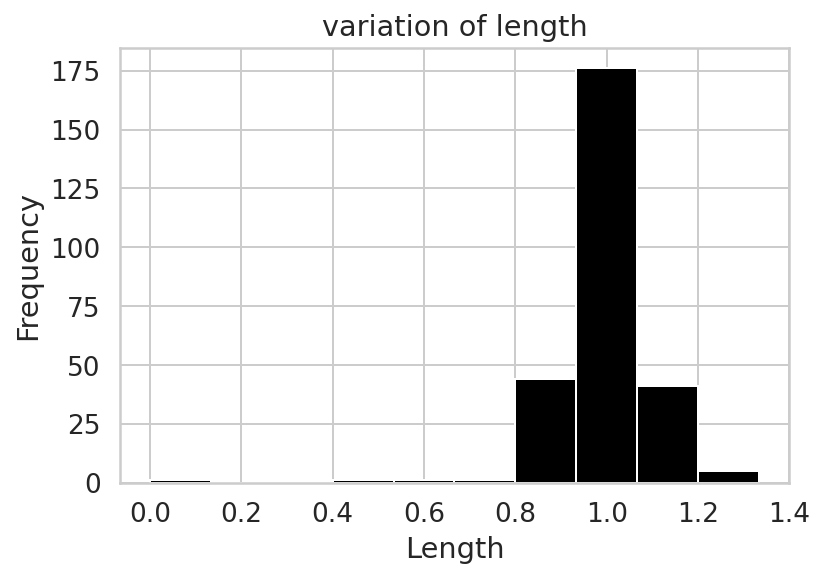

In [ ]:
df_train.groupby('len').mean()['sentiment'].plot.hist(color = 'black', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()